In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

df_ob = pd.read_csv('order_book_snapshot.csv')
df_trades = pd.read_csv('trades.csv')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 100

df_ob['timestamp'] = pd.to_datetime(df_ob['timestamp'], unit='ns')
df_trades['timestamp'] = pd.to_datetime(df_trades['timestamp'], unit='ns')

df_ob_sorted = df_ob.sort_values(by='timestamp').copy()
df_trades_sorted = df_trades.sort_values(by='timestamp').copy()

df_ob_sorted['mid_price'] = (df_ob_sorted['ask_price_1'] - df_ob_sorted['bid_price_1'])/2

for j in range(1, 11):
    bid_vol = df_ob_sorted[f'bid_volume_{j}']
    ask_vol = df_ob_sorted[f'ask_volume_{j}']

    denominator = bid_vol + ask_vol
    numerator = bid_vol - ask_vol

    df_ob_sorted[f'obi_level_{j}'] = numerator.divide(denominator).fillna(0)

max_level_check = 10
cum_ask_cols = []
curr_max_ask_level = 0

for j in range(1, max_level_check+1):
    curr_ask_cols = [f'ask_volume_{i}' for i in range(1, j+1)]

    if all(col in df_ob_sorted.columns for col in curr_ask_cols):
        df_ob_sorted[f'cum_ask_vol_{j}'] = df_ob_sorted[curr_ask_cols].sum(axis=1)
        cum_ask_cols.append(f'cum_ask_vol_{j}')
        curr_max_ask_level = j

cum_bid_cols = []
curr_max_bid_level = 0 

for j in range(1, max_level_check + 1):
    curr_bid_cols = [f'bid_volume_{i}' for i in range(1, j+1)]

    if all(col in df_ob_sorted.columns for col in curr_bid_cols):
        df_ob_sorted[f'cum_bid_vol_{j}'] = df_ob_sorted[curr_bid_cols].sum(axis=1)
        cum_bid_cols.append(f'cum_bid_vol_{j}')
        curr_max_bid_level = j


max_obi_level_actual = min(curr_max_bid_level, curr_max_ask_level)

obi_cum_cols = []

if max_obi_level_actual > 0:
    for j in range(1 , max_obi_level_actual + 1):
        bid_col_name = f'cum_bid_vol_{j}'
        ask_col_name = f'cum_ask_vol_{j}'
        if bid_col_name in df_ob_sorted.columns and ask_col_name in df_ob_sorted.columns:
            cum_bid_vol = df_ob_sorted[bid_col_name]
            cum_ask_vol = df_ob_sorted[ask_col_name]

            numerator_obi = cum_bid_vol - cum_ask_vol
            denominator_obi = cum_bid_vol + cum_ask_vol

            df_ob_sorted[f'obi_cum_level_{j}'] = numerator_obi.divide(denominator_obi).fillna(0)
            obi_cum_cols.append(f'obi_cum_level_{j}')
                

In [6]:
#fiches

predict = 5
df_ob_sorted['future_mid_price'] = df_ob_sorted['mid_price'].shift(-predict)

df_ob_sorted['mid_price_change'] = df_ob_sorted['future_mid_price'] - df_ob_sorted['mid_price']

df_ob_sorted['log_returns'] = np.log(df_ob_sorted['future_mid_price'] / df_ob_sorted['mid_price']).replace([-np.inf, np.inf], np.nan)

price_change_threshold = df_ob_sorted['mid_price'].std() * 0.0001


def get_price_direction(change, threshold):
    if change > threshold:
        return 1
    elif change < -threshold:
        return -1
    else: 
        return
    
df_ob_sorted['price_direction'] = df_ob_sorted['mid_price_change'].apply(lambda x: get_price_direction(x, price_change_threshold))

df_ml = df_ob_sorted.dropna(subset=['future_mid_price', 'mid_price_change', 'log_returns', 'price_direction']).copy()

print(df_ml)

                         timestamp  bid_price_1  bid_volume_1  ask_price_1  \
0    2025-07-06 10:42:24.260275968      99.9994           229     100.0505   
1    2025-07-06 10:42:24.260375968      99.9983           292     100.0487   
2    2025-07-06 10:42:24.260475968     100.0008            99     100.0524   
3    2025-07-06 10:42:24.260575968      99.9961            28     100.0560   
4    2025-07-06 10:42:24.260675968     100.0009           442     100.0534   
...                            ...          ...           ...          ...   
4990 2025-07-06 10:42:24.759275968     100.0719           490     100.1252   
4991 2025-07-06 10:42:24.759375968     100.0745           293     100.1257   
4992 2025-07-06 10:42:24.759475968     100.0754           115     100.1290   
4993 2025-07-06 10:42:24.759575968     100.0800           295     100.1240   
4994 2025-07-06 10:42:24.759675968     100.0768           202     100.1256   

      ask_volume_1  bid_price_2  bid_volume_2  ask_price_2  ask

learning has bid ended
Root Mean Squared Error (RMSE): 0.00476830
Top of features
obi_level_2        0.069624
obi_level_10       0.064455
obi_level_3        0.064411
obi_level_6        0.063817
obi_level_9        0.063448
obi_level_7        0.058773
obi_level_5        0.058045
obi_level_8        0.056080
obi_level_4        0.054573
obi_cum_level_2    0.048827
dtype: float64


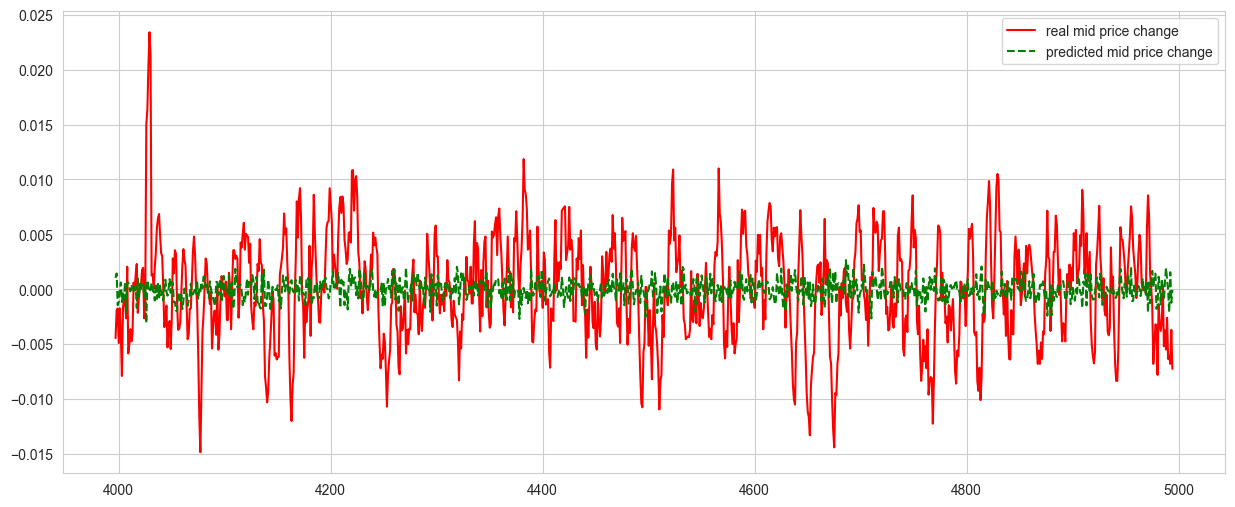

In [9]:
features = []

for j in range(1, 11):
    if f'obi_level_{j}' in df_ml.columns:
        features.append(f'obi_level_{j}')
    else:
        break

for j in range(1, max_obi_level_actual + 1):
    if f'obi_cum_level_{j}' in df_ml.columns:
        features.append(f'obi_cum_level_{j}')
    else:
        break

X = df_ml[features]
y = df_ml['mid_price_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#randomforestregressor
model_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_reg.fit(X_train, y_train)
print("learning has bid ended")

y_pred_reg = model_reg.predict(X_test)

rmse = np.sqrt (mean_squared_error(y_test, y_pred_reg))
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")

feature_importances = pd.Series(model_reg.feature_importances_, index=features).sort_values(ascending=False)
print("Top of features")
print(feature_importances.head(10))

plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='real mid price change', color='red')
plt.plot(y_test.index, y_pred_reg, linestyle='--', label='predicted mid price change', color='green')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
X = df_ml[features]
y = df_ml['price_direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model_cls = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
model_cls.fit(X_train, y_train)
print("learning has bid ended")

y_pred_cls = model_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_cls)
print(f"Accuracy: {accuracy:.8f}")
print(classification_report(y_test, y_pred_cls))

feature_importances = pd.Series(model_cls.feature_importances_, index=features).sort_values(ascending=False)
print("Top of features")
print(feature_importances.head(10))

print(classification_report(y_test, y_pred_cls))

learning has bid ended
Accuracy: 0.48393574
              precision    recall  f1-score   support

        -1.0       0.49      0.47      0.48       502
         1.0       0.48      0.50      0.49       494

    accuracy                           0.48       996
   macro avg       0.48      0.48      0.48       996
weighted avg       0.48      0.48      0.48       996

Top of features
obi_level_3        0.056971
obi_level_10       0.056209
obi_level_2        0.054429
obi_level_7        0.052393
obi_level_9        0.052236
obi_level_8        0.052164
obi_level_4        0.051931
obi_level_5        0.051444
obi_cum_level_2    0.050845
obi_level_6        0.050146
dtype: float64
              precision    recall  f1-score   support

        -1.0       0.49      0.47      0.48       502
         1.0       0.48      0.50      0.49       494

    accuracy                           0.48       996
   macro avg       0.48      0.48      0.48       996
weighted avg       0.48      0.48      0.48   